In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yfin
import MG_Formulas as MG
import statsmodels.api as sm
import itertools
import getFamaFrenchFactors as gff
import pandas_datareader.data as pdr
from pypfopt.efficient_frontier import EfficientFrontier
from matplotlib.ticker import MultipleLocator
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set()
%load_ext autoreload
%autoreload 2

# PROJECT: CONSTRUCT A FAMA FRENCH 3 FATORS PORFOLIO OF 10 STOCKS 

BY: ING. MATEO GUTIERREZ ACOSTA

DATE: 20/07/24

### GET DATA

In [3]:
Start = dt.datetime(2010, 12, 1)
End = dt.datetime.now()
Start, End

(datetime.datetime(2010, 12, 1, 0, 0),
 datetime.datetime(2024, 9, 10, 14, 1, 58, 447706))

In [4]:
Stocks = ["NVDA", "TSLA", "INTC", "AMZN",
          "MSFT", "GOOGL", "AMD", "AAPL", "^GSPC"]


len(Stocks)


yfin.pdr_override()


df = pdr.get_data_yahoo(Stocks, Start, End, interval="1mo")


df = df["Adj Close"]

ffdf = gff.famaFrench3Factor()
ff4df = gff.carhart4Factor()  # Get the Fama French 3 factor
ffdf
ff4df

9

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  9 of 9 completed


,date_ff_factors,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...,...
1172,2024-03-31,0.0283,-0.0251,0.0421,0.0043
1173,2024-04-30,-0.0467,-0.0239,-0.0052,0.0047
1174,2024-05-31,0.0434,0.0078,-0.0166,0.0044
1175,2024-06-30,0.0277,-0.0306,-0.0331,0.0041


,date_ff_factors,Mkt-RF,SMB,HML,RF,MOM
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022,NaN
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025,NaN
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023,NaN
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032,NaN
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031,NaN
...,...,...,...,...,...,...
1172,2024-03-31,0.0283,-0.0251,0.0421,0.0043,-0.0040
1173,2024-04-30,-0.0467,-0.0239,-0.0052,0.0047,-0.0042
1174,2024-05-31,0.0434,0.0078,-0.0166,0.0044,-0.0001
1175,2024-06-30,0.0277,-0.0306,-0.0331,0.0041,0.0090


####  RETURNS AND FAMA FRENCH DATA


Stocks returns:

get monthly and annual returns df

In [5]:
df_mR = df.pct_change().dropna()
df_yR = MG.compound_period(df_mR, period="YE")
df_yR = df_yR.to_period("Y")
df_mR = df_mR.to_period("M")
df_mR.head(3)
df_yR.head(3)

Ticker,AAPL,AMD,AMZN,GOOGL,INTC,MSFT,NVDA,TSLA,^GSPC
Date,,,,,,,,,
2011-01,0.051959,-0.042787,-0.057556,0.010758,0.020447,-0.006449,0.553247,-0.095005,0.022646
2011-02,0.040935,0.176245,0.021516,0.021720,0.000466,-0.041471,-0.052676,-0.008714,0.031957
2011-03,-0.013306,-0.066232,0.039471,-0.043430,-0.052126,-0.039125,-0.185349,0.161574,-0.001047


Ticker,AAPL,AMD,AMZN,GOOGL,INTC,MSFT,NVDA,TSLA,^GSPC
Date,,,,,,,,,
2011,0.255581,-0.339853,-0.038333,0.087429,0.193964,-0.045156,-0.100000,0.072475,-0.000032
2012,0.325669,-0.555556,0.449278,0.095185,-0.120146,0.057988,-0.109733,0.185924,0.134057
2013,0.080695,0.612500,0.589628,0.584311,0.309201,0.442980,0.335238,3.441394,0.296012


Fama french Returns:


REINDEX, DIVIDE 100 AND MATCH DATES

In [6]:
ffdf.set_index("date_ff_factors", inplace=True)
ffdf.index = pd.to_datetime(ffdf.index, format="%Y%m").to_period('M')
ffdf = ffdf.loc[df_mR.index.min():]  # INITIAL DATE
df_mR = df_mR.loc[:ffdf.index.max()]  # FINAL DATE
ffdf.head(2)
df_mR.tail(2)

,Mkt-RF,SMB,HML,RF
date_ff_factors,,,,
2011-01,0.0199,-0.0250,0.0082,0.0001
2011-02,0.0349,0.0153,0.0127,0.0001


Ticker,AAPL,AMD,AMZN,GOOGL,INTC,MSFT,NVDA,TSLA,^GSPC
Date,,,,,,,,,
2024-06,0.097039,-0.028101,0.095273,0.055942,0.007967,0.078593,0.126850,0.111186,0.034670
2024-07,0.054411,-0.109303,-0.032445,-0.057168,-0.007427,-0.063989,-0.052699,0.172781,0.011321


In [7]:
mkt_excess = ffdf.loc[:, ['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
exp_var["Size"] = ffdf.loc[:, ['SMB']]
exp_var["Value"] = ffdf.loc[:, ['HML']]
exp_var.head()

,Mkt-RF,Constant,Size,Value
date_ff_factors,,,,
2011-01,0.0199,1,-0.0250,0.0082
2011-02,0.0349,1,0.0153,0.0127
2011-03,0.0046,1,0.0254,-0.0183
2011-04,0.0290,1,-0.0038,-0.0243
2011-05,-0.0127,1,-0.0059,-0.0212


In [8]:
df_mR_excess = df_mR - ffdf.loc[:, ["RF"]].values
df_mR_excess.head(3)

Ticker,AAPL,AMD,AMZN,GOOGL,INTC,MSFT,NVDA,TSLA,^GSPC
Date,,,,,,,,,
2011-01,0.051859,-0.042887,-0.057656,0.010658,0.020347,-0.006549,0.553147,-0.095105,0.022546
2011-02,0.040835,0.176145,0.021416,0.021620,0.000366,-0.041571,-0.052776,-0.008814,0.031857
2011-03,-0.013406,-0.066332,0.039371,-0.043530,-0.052226,-0.039225,-0.185449,0.161474,-0.001147


In [9]:
FF = ((np.linalg.inv(exp_var.T @ exp_var)) @ exp_var.T)@df_mR_excess
FF.set_index(exp_var.columns, inplace=True)
FF

Ticker,AAPL,AMD,AMZN,GOOGL,INTC,MSFT,NVDA,TSLA,^GSPC
Mkt-RF,1.184551,2.072229,1.225898,1.045362,0.933039,1.004609,1.773065,1.645809,0.983538
Constant,0.008132,0.007028,0.007377,0.004747,-0.002801,0.007518,0.023675,0.026329,-0.001401
Size,-0.341986,0.093314,-0.215497,-0.466548,-0.134028,-0.694946,-0.356671,1.008636,-0.146532
Value,-0.550520,-0.801846,-0.989290,-0.279685,0.028114,-0.390845,-0.933634,-1.064079,0.013301


### EXPECTED RETURNS AND Risk Free rate
FAMA FRENCH RETURNS
$$ R_i= rf + B_1(R_m-rf) + B_2(SMB) + B_3(HML) + C $$

coeficientes

In [10]:
Rm_rf = MG.expected_returns(ffdf["Mkt-RF"])
SMB = MG.expected_returns(ffdf["SMB"])
HML = MG.expected_returns(ffdf["HML"])
mriskfree = MG.expected_returns(ffdf["RF"])
yriskfree = mriskfree*12

Betas

In [11]:
B1 = FF.loc["Mkt-RF"]
B2 = FF.loc["Size"]
B3 = FF.loc["Value"]
C = FF.loc["Constant"]

FF Retorno

In [12]:
FF_EMR = mriskfree + (B1*Rm_rf) + (B2*SMB) + (B3*HML) + C
FF_EMR

Ticker
AAPL     0.021694
AMD      0.028805
AMZN     0.021805
GOOGL    0.016757
INTC     0.007182
MSFT     0.019643
NVDA     0.043457
TSLA     0.043070
^GSPC    0.009105
dtype: float64

In [13]:
ffdf

,Mkt-RF,SMB,HML,RF
date_ff_factors,,,,
2011-01,0.0199,-0.0250,0.0082,0.0001
2011-02,0.0349,0.0153,0.0127,0.0001
2011-03,0.0046,0.0254,-0.0183,0.0001
2011-04,0.0290,-0.0038,-0.0243,0.0000
2011-05,-0.0127,-0.0059,-0.0212,0.0000
...,...,...,...,...
2024-03,0.0283,-0.0251,0.0421,0.0043
2024-04,-0.0467,-0.0239,-0.0052,0.0047
2024-05,0.0434,0.0078,-0.0166,0.0044


Intervals

In [14]:
MG.returns_interval(df_mR)

----------AAPL-------------
  MIN   AVG   MAX
-0.184 0.022 0.214

    INTERVALS        P%
(0.0152, 0.115]      41.0
(-0.0844, 0.0152]    39.0
(0.115, 0.214]       10.0
(-0.185, -0.0844]    10.0
Name: count, dtype: float64
----------AMD-------------
  MIN   AVG   MAX
-0.41 0.03 0.472

    INTERVALS        P%
(-0.19, 0.0306]    47.0
(0.0306, 0.251]    37.0
(0.251, 0.472]      9.0
(-0.412, -0.19]     7.0
Name: count, dtype: float64
----------AMZN-------------
  MIN   AVG   MAX
-0.238 0.022 0.271

    INTERVALS        P%
(0.0165, 0.144]    48.0
(-0.11, 0.0165]    42.0
(0.144, 0.271]      7.0
(-0.239, -0.11]     4.0
Name: count, dtype: float64
----------GOOGL-------------
  MIN   AVG   MAX
-0.179 0.017 0.218

    INTERVALS        P%
(-0.0802, 0.019]     45.0
(0.019, 0.118]       40.0
(0.118, 0.218]        8.0
(-0.181, -0.0802]     7.0
Name: count, dtype: float64
----------INTC-------------
  MIN   AVG   MAX
-0.31 0.008 0.326

    INTERVALS        P%
(0.00814, 0.167]     48.0
(-0.151, 0.0081

Summary statistics

In [22]:
MG.summary_stats(df_mR, riskFree=mriskfree)

,Exp Return,Exp Vol,Sharpe Ratio,Calamari Ratio,MG Ratio,VaR H (5%),VaR (5%),Max Drawdonw,Is Normal,Skew,Kurt
Ticker,,,,,,,,,,,
AAPL,0.021051,0.077969,0.258308,0.050933,0.184891,0.111981,0.108929,-0.395421,False,-0.069837,-0.385018
AMD,0.025716,0.159889,0.155138,0.030501,0.113339,0.205025,0.218856,-0.813246,False,0.208143,0.027434
AMZN,0.021005,0.085078,0.236184,0.038571,0.184263,0.100479,0.109051,-0.520968,False,0.242031,0.662324
GOOGL,0.016351,0.068239,0.226274,0.038216,0.162043,0.095746,0.095287,-0.404037,False,0.136890,0.193520
INTC,0.006602,0.079835,0.071287,0.009695,0.045838,0.120859,0.124159,-0.587014,False,-0.142971,2.412857
MSFT,0.019352,0.059979,0.307467,0.060408,0.239806,0.075272,0.076902,-0.305285,False,0.218628,0.265115
NVDA,0.041455,0.131261,0.308885,0.064529,0.236458,0.180984,0.171466,-0.628317,False,0.372242,1.213469
TSLA,0.039555,0.178224,0.216830,0.057065,0.203037,0.196806,0.190331,-0.677190,False,1.201579,2.792667
^GSPC,0.009191,0.041325,0.200362,0.033428,0.134128,0.065465,0.061732,-0.247695,False,-0.378129,0.769787


Value at risk (5%)

In [23]:
MG.ValueAtRisk(df_mR)

,Is_normal,Historic,Gaussian,Cornish-Fisher,AVG
Ticker,,,,,
AAPL,True,0.111981,0.105878,NaN,0.108929
AMD,True,0.205025,0.232688,NaN,0.218856
AMZN,True,0.100479,0.117624,NaN,0.109051
GOOGL,True,0.095746,0.094829,NaN,0.095287
INTC,False,0.120859,NaN,0.127459,0.124159
MSFT,True,0.075272,0.078532,NaN,0.076902
NVDA,False,0.180984,NaN,0.161947,0.171466
TSLA,False,0.196806,NaN,0.183855,0.190331
^GSPC,True,0.065465,0.057999,NaN,0.061732


In [26]:
print("---Min Return---")
df_mR.min()
print("---Mean Return---")
df_mR.mean()
print("---Max Return---")
df_mR.max()

---Min Return---


Ticker
AAPL    -0.184044
AMD     -0.410489
AMZN    -0.237525
GOOGL   -0.179467
INTC    -0.310165
MSFT    -0.130248
NVDA    -0.320158
TSLA    -0.367334
^GSPC   -0.125119
dtype: float64

---Mean Return---


Ticker
AAPL     0.022370
AMD      0.030307
AMZN     0.022317
GOOGL    0.017414
INTC     0.008017
MSFT     0.020124
NVDA     0.044459
TSLA     0.044336
^GSPC    0.009975
dtype: float64

---Max Return---


Ticker
AAPL     0.214379
AMD      0.471773
AMZN     0.270596
GOOGL    0.217502
INTC     0.326437
MSFT     0.196262
NVDA     0.553247
TSLA     0.810706
^GSPC    0.126844
dtype: float64

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12356\4211781685.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_mR.iloc[:, i])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12356\4211781685.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_mR.iloc[:, i])
C:\Users\ASUS\AppData\Loca

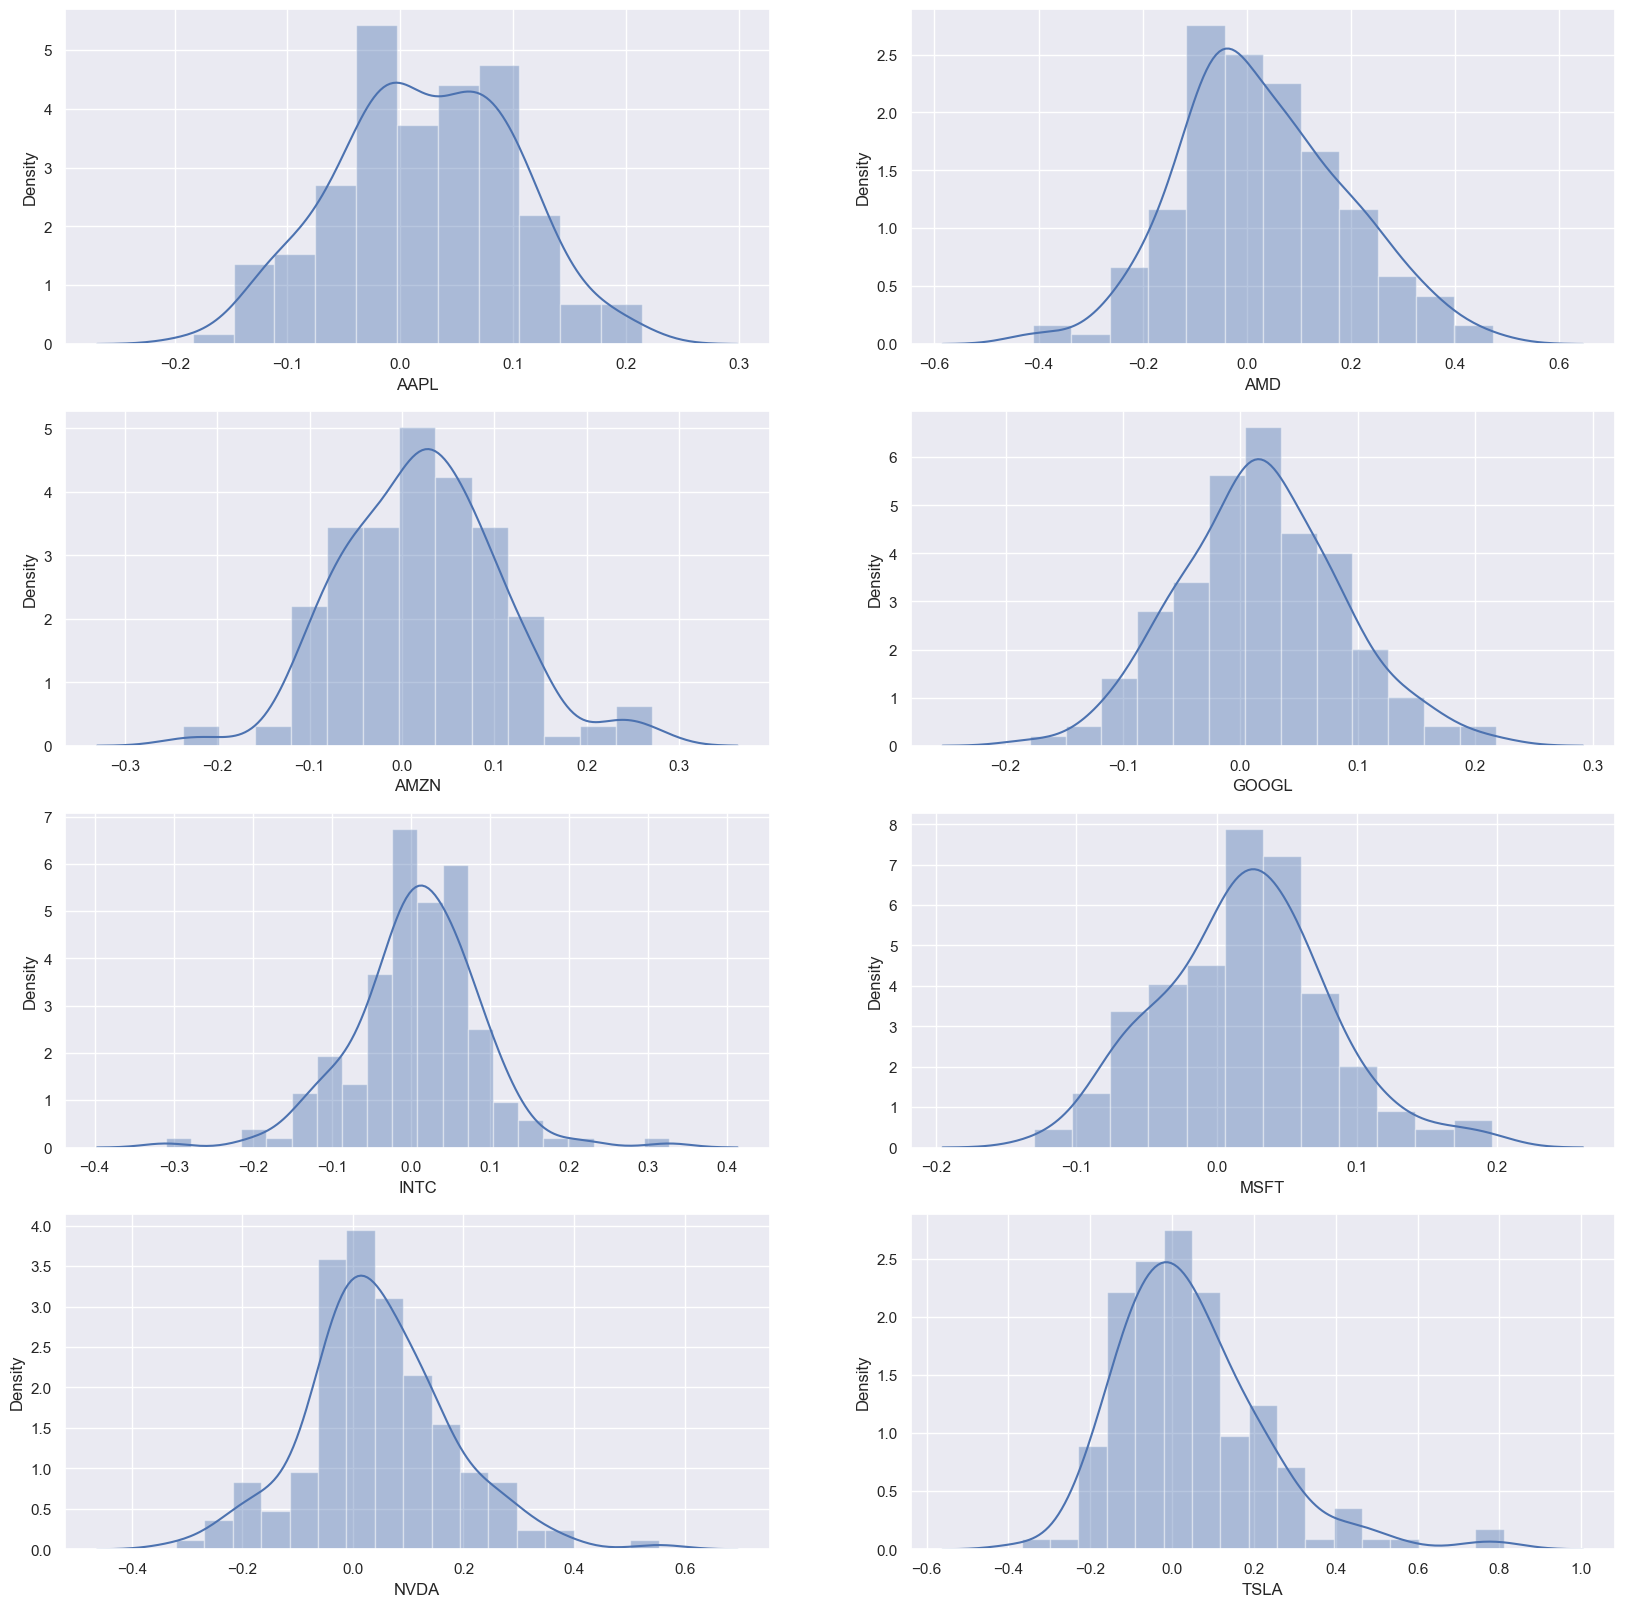

In [36]:
InteractiveShell.ast_node_interactivity = "last_expr"
plt.figure(figsize=(20, 20))
# plt.title("RETURN DISTRIBUTIONS OF THE ASSETS")
for i in range(0, len(Stocks)-1):
    plt.subplot(4, 2, i+1)
    ax = sns.distplot(df_mR.iloc[:, i])

Different methods of calculating Expected Return

In [ ]:
MER1 = df_mR.median()
MER2 = MG.expected_returns(df_mR)
MER3 = df_mR.mean()

<Axes: title={'center': 'Comparison of Different Methods of Returns'}, xlabel='Ticker'>

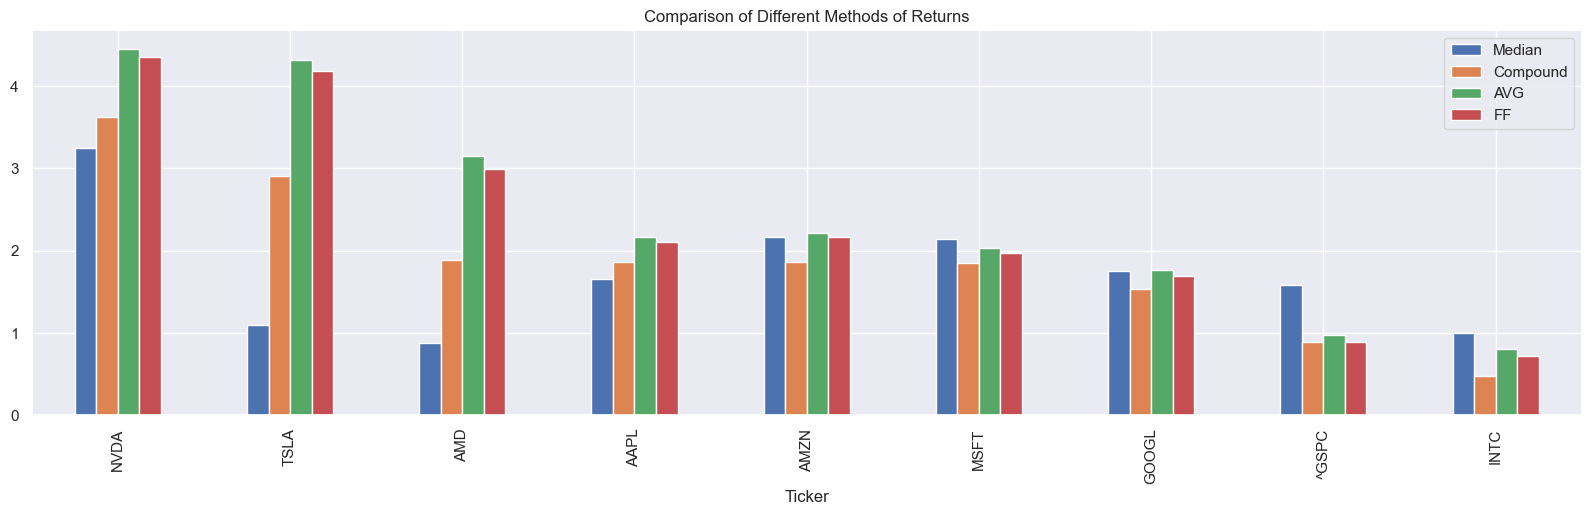

In [ ]:
R_list = [MER1*100, MER2*100, MER3*100, FF_EMR*100]
compare_R = pd.concat(R_list, axis=1)
compare_R.columns = ["Median", "Compound", "AVG", "FF"]
compare_R.sort_values(by="Compound", ascending=False).plot(figsize=(20, 5), kind='bar',
                                                           title="Comparison of Different Methods of Returns")

In [ ]:
compare_R

,Median,Compound,AVG,FF
Ticker,,,,
AAPL,1.662357,1.868952,2.170751,2.103093
AMD,0.884955,1.890760,3.153665,2.999191
AMZN,2.167729,1.865483,2.220415,2.167288
GOOGL,1.748613,1.534289,1.763767,1.695282
INTC,0.995697,0.483825,0.811337,0.726516
MSFT,2.138060,1.853794,2.028355,1.977398
NVDA,3.248464,3.628226,4.455095,4.351242
TSLA,1.103428,2.903620,4.312253,4.187801
^GSPC,1.589571,0.894798,0.981305,0.893258


In [ ]:
MG.annualized_returns(compare_R/100)

Median      0.328853
Compound    0.251993
AVG         0.290244
Beta        0.138865
dtype: float64

### Drawdonw

In [ ]:
MG.drawdown2(df_mR).min()

Ticker
AAPL    -0.395421
AMD     -0.813246
AMZN    -0.520968
GOOGL   -0.404037
INTC    -0.587014
MSFT    -0.305285
NVDA    -0.628317
TSLA    -0.677190
^GSPC   -0.247695
dtype: float64

----Max Drawdown----


Ticker
AMD     -0.813246
TSLA    -0.677190
NVDA    -0.628317
INTC    -0.587014
AMZN    -0.520968
GOOGL   -0.404037
AAPL    -0.395421
MSFT    -0.305285
^GSPC   -0.247695
dtype: float64

----AVG Drawdown----


Ticker
AMD     -0.323154
NVDA    -0.184874
TSLA    -0.166396
INTC    -0.140221
AMZN    -0.091446
AAPL    -0.084339
GOOGL   -0.066292
MSFT    -0.043598
^GSPC   -0.035880
dtype: float64

<Axes: xlabel='Date'>

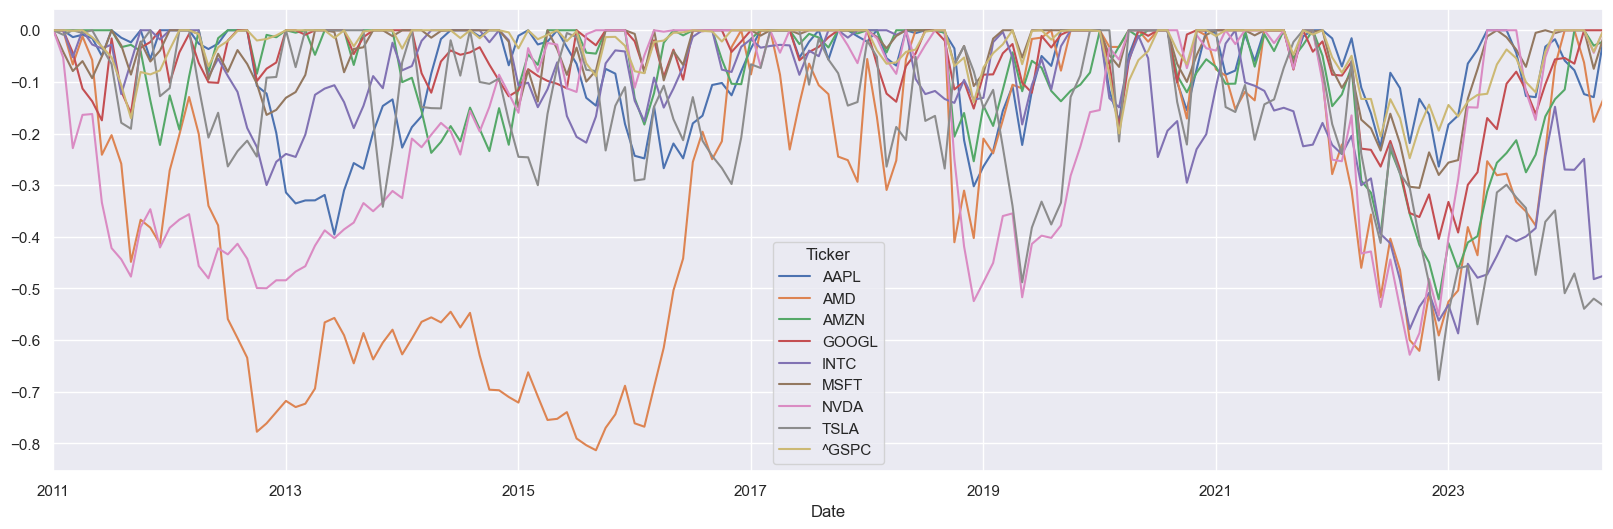

In [ ]:
dd = MG.drawdown(df_mR)
print("----Max Drawdown----")


dd.min().sort_values()
print("----AVG Drawdown----")


dd.mean().sort_values()


dd.plot(figsize=(20, 6))

ESTIMATE THE COVARIENCE

weights

In [ ]:
MG.weight_gmv(df_mR)

array([0.        , 0.        , 0.        , 0.        , 0.00286008,
       0.06040848, 0.        , 0.        , 0.93673176])

In [ ]:
df_mR.columns

Index(['AAPL', 'AMD', 'AMZN', 'GOOGL', 'INTC', 'MSFT', 'NVDA', 'TSLA',
       '^GSPC'],
      dtype='object', name='Ticker')

<Axes: >

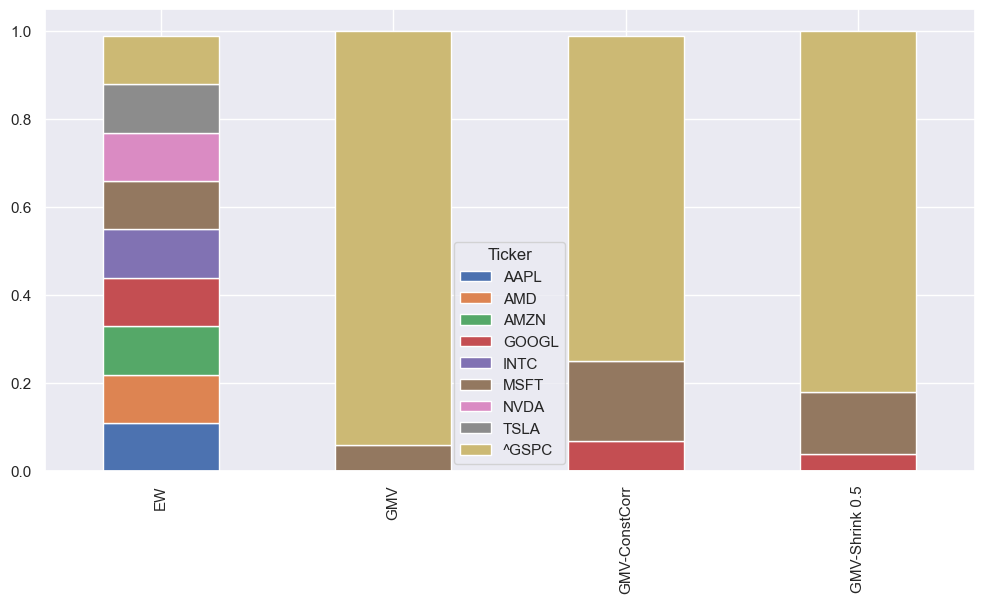

In [ ]:
wts = pd.DataFrame({
    "EW": MG.weight_EW(df_mR),
    "GMV": MG.weight_gmv(df_mR, cov_estimator=1),
    "GMV-ConstCorr": MG.weight_gmv(df_mR, cov_estimator=2),
    "GMV-Shrink 0.5": MG.weight_gmv(df_mR, cov_estimator=3),
}, index=df_mR.columns)
wts.T.plot.bar(stacked=True, figsize=(12, 6), legend=True)

In [ ]:
wts.loc["#_Stocks"] = wts[wts > 0].count().round(0)
wts

,EW,GMV-Sample,GMV-ConstCorr,GMV-Shrink 0.5
Ticker,,,,
AAPL,11.0,0.0,0.0,0.0
AMD,11.0,0.0,0.0,0.0
AMZN,11.0,0.0,0.0,0.0
GOOGL,11.0,0.0,7.0,4.0
INTC,11.0,0.0,0.0,0.0
MSFT,11.0,6.0,18.0,14.0
NVDA,11.0,0.0,0.0,0.0
TSLA,11.0,0.0,0.0,0.0
^GSPC,11.0,94.0,74.0,82.0


In [ ]:
wts.loc["#_Stocks"]-(wts.sum())

EW               -1.0
GMV-Sample       -1.0
GMV-ConstCorr    -1.0
GMV-Shrink 0.5   -1.0
dtype: float64

Backtest simulation

<Axes: title={'center': 'My Portfolios'}, xlabel='Date'>

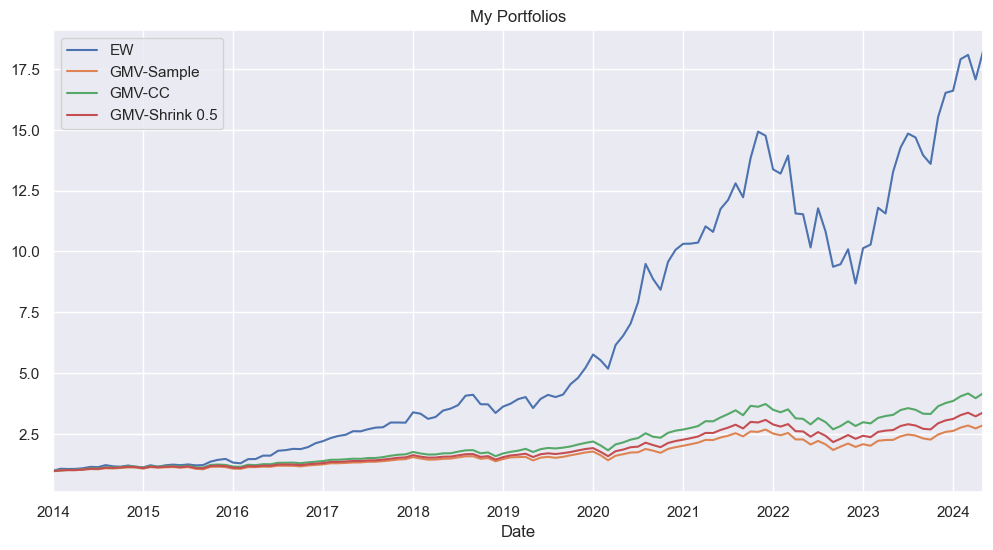

In [ ]:
ewr = MG.backtest_ws(df_mR, estimation_window=36,
                     weighting=MG.weight_EW)
mv_s_r = MG.backtest_ws(df_mR, estimation_window=36,
                        weighting=MG.weight_gmv, cov_estimator=1)
mv_cc_r = MG.backtest_ws(df_mR, estimation_window=36,
                         weighting=MG.weight_gmv, cov_estimator=2)
mv_sh_r = MG.backtest_ws(df_mR, estimation_window=36,
                         weighting=MG.weight_gmv, cov_estimator=3, delta=0.5)
btr = pd.DataFrame({"EW": ewr, "GMV-Sample": mv_s_r,
                   "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r}).dropna()
(1+btr).cumprod().plot(figsize=(12, 6), title="My Portfolios ")

In [ ]:
MG.expected_returns(df_mR)
FF_EMR
MG.ValueAtRisk(df_mR)["AVG"]

Ticker
AAPL     0.018690
AMD      0.018908
AMZN     0.018655
GOOGL    0.015343
INTC     0.004838
MSFT     0.018538
NVDA     0.036282
TSLA     0.029036
^GSPC    0.008948
dtype: float64

Ticker
AAPL     0.021031
AMD      0.029992
AMZN     0.021673
GOOGL    0.016953
INTC     0.007265
MSFT     0.019774
NVDA     0.043512
TSLA     0.041878
^GSPC    0.008933
dtype: float64

Ticker
AAPL     0.109678
AMD      0.219198
AMZN     0.109330
GOOGL    0.095644
INTC     0.124626
MSFT     0.076718
NVDA     0.172437
TSLA     0.191131
^GSPC    0.062142
Name: AVG, dtype: float64

In [ ]:
MG.mg_ratio(df_mR, mriskfree, expected_return=FF_EMR)

Ticker
AAPL     0.183831
AMD      0.132863
AMZN     0.190288
GOOGL    0.168167
INTC     0.051325
MSFT     0.246425
NVDA     0.247300
TSLA     0.214561
^GSPC    0.129766
dtype: float64

In [ ]:
MG.summary_stats(r=df_mR, riskFree=mriskfree, expected_return=FF_EMR)

,Exp Return,Exp Vol,Sharpe Ratio,Calamari Ratio,MG Ratio,VaR H (5%),VaR (5%),Max Drawdonw,Is Normal,Skew,Kurt
Ticker,,,,,,,,,,,
AAPL,0.021031,0.078188,0.257870,0.050989,0.183831,0.112457,0.109678,-0.395421,False,-0.050342,-0.389276
AMD,0.029992,0.160432,0.181530,0.035811,0.132863,0.206046,0.219198,-0.813246,False,0.189840,0.014091
AMZN,0.021673,0.085303,0.243887,0.039934,0.190288,0.100554,0.109330,-0.520968,False,0.244886,0.666597
GOOGL,0.016953,0.068342,0.235349,0.039809,0.168167,0.096514,0.095644,-0.404037,False,0.135085,0.203095
INTC,0.007265,0.080320,0.079638,0.010897,0.051325,0.120903,0.124626,-0.587014,False,-0.145740,2.350312
MSFT,0.019774,0.059808,0.316101,0.061927,0.246425,0.075345,0.076718,-0.305285,False,0.226796,0.312215
NVDA,0.043512,0.131691,0.323816,0.067870,0.247300,0.182319,0.172437,-0.628317,False,0.372098,1.207234
TSLA,0.041878,0.178960,0.229154,0.060558,0.214561,0.197346,0.191131,-0.677190,False,1.219579,2.801737
^GSPC,0.008933,0.041535,0.194147,0.032556,0.129766,0.065778,0.062142,-0.247695,False,-0.366622,0.733639


In [ ]:
MG.summary_stats(df_mR, mriskfree)

,Exp Return,Exp Vol,Sharpe Ratio,Calamari Ratio,MG Ratio,VaR H (5%),VaR (5%),Max Drawdonw,Is Normal,Skew,Kurt
Ticker,,,,,,,,,,,
AAPL,0.018690,0.078188,0.227924,0.045068,0.162483,0.112457,0.109678,-0.395421,False,-0.050342,-0.389276
AMD,0.018908,0.160432,0.112440,0.022181,0.082295,0.206046,0.219198,-0.813246,False,0.189840,0.014091
AMZN,0.018655,0.085303,0.208506,0.034141,0.162683,0.100554,0.109330,-0.520968,False,0.244886,0.666597
GOOGL,0.015343,0.068342,0.211792,0.035824,0.151334,0.096514,0.095644,-0.404037,False,0.135085,0.203095
INTC,0.004838,0.080320,0.049422,0.006762,0.031852,0.120903,0.124626,-0.587014,False,-0.145740,2.350312
MSFT,0.018538,0.059808,0.295434,0.057878,0.230314,0.075345,0.076718,-0.305285,False,0.226796,0.312215
NVDA,0.036282,0.131691,0.268913,0.056363,0.205371,0.182319,0.172437,-0.628317,False,0.372098,1.207234
TSLA,0.029036,0.178960,0.157396,0.041595,0.147373,0.197346,0.191131,-0.677190,False,1.219579,2.801737
^GSPC,0.008948,0.041535,0.194518,0.032618,0.130014,0.065778,0.062142,-0.247695,False,-0.366622,0.733639


In [ ]:
MG.summary_stats(df_yR, yriskfree)

,Exp Return,Exp Vol,Sharpe Ratio,Calamari Ratio,MG Ratio,VaR H (5%),VaR (5%),Max Drawdonw,Is Normal,Skew,Kurt
Ticker,,,,,,,,,,,
AAPL,0.248581,0.312067,0.763161,0.901967,1.345314,0.127451,0.177027,-0.264042,False,0.361221,-0.092639
AMD,0.224887,0.939092,0.228372,0.386033,0.267036,0.551877,0.803123,-0.555556,False,1.236332,1.802345
AMZN,0.239820,0.427695,0.536354,0.462350,0.651572,0.317804,0.352065,-0.496152,False,0.108333,-0.046711
GOOGL,0.188712,0.281631,0.633056,0.456102,0.869669,0.171875,0.205007,-0.390895,False,-0.342477,-0.056437
INTC,0.058596,0.342466,0.140662,0.093131,0.112543,0.404886,0.428031,-0.517251,False,0.596649,1.326545
MSFT,0.237492,0.240990,0.942228,0.810241,1.743404,0.127438,0.130244,-0.280248,False,-0.623867,0.076849
NVDA,0.509924,0.858485,0.581839,0.993860,0.947155,0.376204,0.527369,-0.502586,False,0.537551,-0.366102
TSLA,0.410854,2.019796,0.198252,0.615747,1.254727,0.302634,0.319137,-0.650315,False,2.736286,7.780267
^GSPC,0.110556,0.138382,0.723585,0.515005,0.925180,0.108592,0.108229,-0.194428,False,-0.753378,0.143524


In [ ]:
df_mR.cov()
sample = MG.sample_cov(df_mR)
cc_cov = MG.cc_cov(df_mR)
sh_cov = MG.shrinkage_cov(df_mR)

Ticker,AAPL,AMD,AMZN,GOOGL,INTC,MSFT,NVDA,TSLA,^GSPC
Ticker,,,,,,,,,
AAPL,0.006152,0.004614,0.003146,0.002281,0.002129,0.002458,0.004732,0.005450,0.002002
AMD,0.004614,0.025899,0.006299,0.003813,0.003241,0.004318,0.010786,0.008914,0.003684
AMZN,0.003146,0.006299,0.007322,0.003062,0.001953,0.002640,0.004638,0.005058,0.002048
GOOGL,0.002281,0.003813,0.003062,0.004700,0.001574,0.002129,0.003589,0.003558,0.001742
INTC,0.002129,0.003241,0.001953,0.001574,0.006492,0.002408,0.003553,0.002702,0.001669
MSFT,0.002458,0.004318,0.002640,0.002129,0.002408,0.003599,0.003860,0.003420,0.001605
NVDA,0.004732,0.010786,0.004638,0.003589,0.003553,0.003860,0.017451,0.006715,0.003025
TSLA,0.005450,0.008914,0.005058,0.003558,0.002702,0.003420,0.006715,0.032227,0.002990
^GSPC,0.002002,0.003684,0.002048,0.001742,0.001669,0.001605,0.003025,0.002990,0.001736


## EFFICIENT FRONTIER

**MONTHLY**

Normal Covarience

--------PORTFOLIO SUMMARY--------
-----MAXIMUN SHARPE RATIO------
Exp. Return: 2.8
Exp. Vol: 6.98
Exp. SHARPE: 0.388
----GLOBAL MINIMUN VARIANCE----
Exp. Return: 0.96
Exp. Vol: 4.16
Exp. SHARPE: 0.21


<Axes: title={'center': 'MONTHLY EFFICIENT FRONTIER'}, xlabel='STD Risk', ylabel='Returns'>

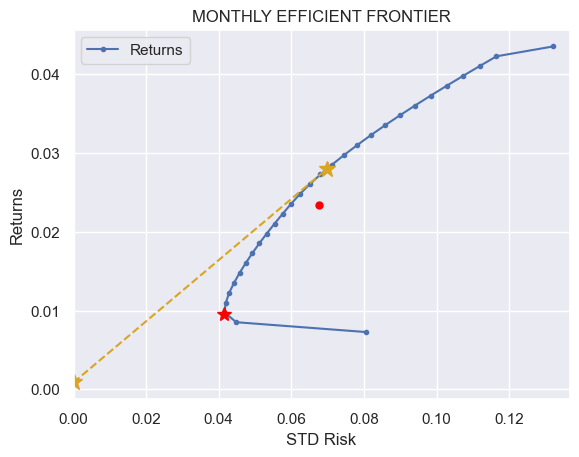

In [ ]:
MG.plot_ef(30, FF_EMR, sample, mriskfree, "MONTHLY EFFICIENT FRONTIER")

Elton/Gruber Constant Correlation model (Covarience)

--------PORTFOLIO SUMMARY--------
-----MAXIMUN SHARPE RATIO------
Exp. Return: 2.57
Exp. Vol: 6.37
Exp. SHARPE: 0.389
----GLOBAL MINIMUN VARIANCE----
Exp. Return: 1.15
Exp. Vol: 3.97
Exp. SHARPE: 0.268


<Axes: title={'center': 'MONTHLY EFFICIENT FRONTIER'}, xlabel='STD Risk', ylabel='Returns'>

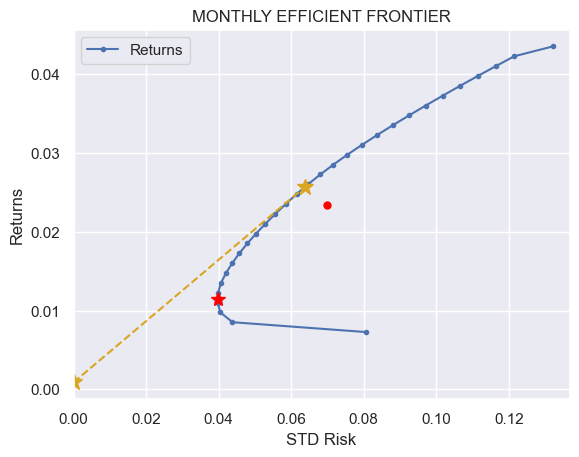

In [ ]:
MG.plot_ef(30, FF_EMR, cc_cov, mriskfree, "MONTHLY EFFICIENT FRONTIER")

--------PORTFOLIO SUMMARY--------
-----MAXIMUN SHARPE RATIO------
Number of stocks to invest: 6
Ticker
MSFT     46.0
NVDA     23.0
AAPL     14.0
AMZN      8.0
GOOGL     7.0
TSLA      2.0
dtype: float64
----GLOBAL MINIMUN VARIANCE----
Number of stocks to invest: 3
Ticker
^GSPC    74.0
MSFT     18.0
GOOGL     7.0
dtype: float64


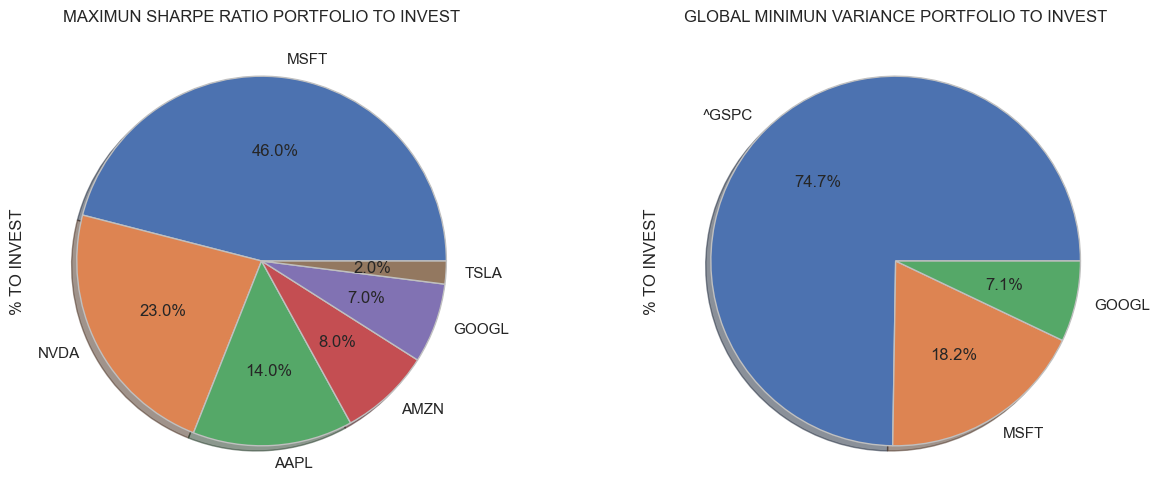

In [ ]:
MG.show_porfolio(FF_EMR, cc_cov, mriskfree)

shrinkage covarience

--------PORTFOLIO SUMMARY--------
-----MAXIMUN SHARPE RATIO------
Exp. Return: 2.69
Exp. Vol: 6.72
Exp. SHARPE: 0.387
----GLOBAL MINIMUN VARIANCE----
Exp. Return: 1.07
Exp. Vol: 4.09
Exp. SHARPE: 0.241


<Axes: title={'center': 'MONTHLY EFFICIENT FRONTIER'}, xlabel='STD Risk', ylabel='Returns'>

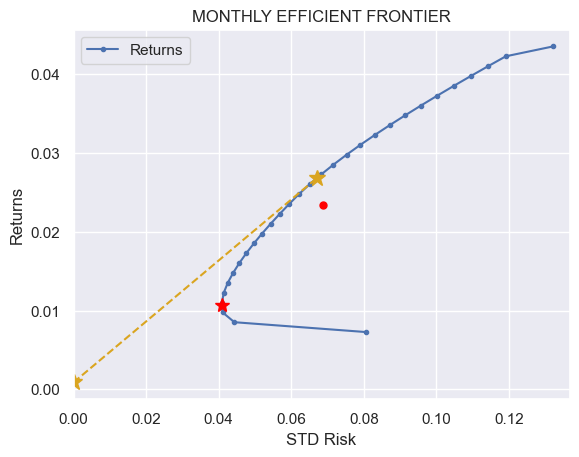

In [ ]:
MG.plot_ef(30, FF_EMR, sh_cov, mriskfree, "MONTHLY EFFICIENT FRONTIER")

--------PORTFOLIO SUMMARY--------
-----MAXIMUN SHARPE RATIO------
Number of stocks to invest: 6
Ticker
MSFT     44.0
NVDA     25.0
TSLA     10.0
AAPL      7.0
GOOGL     7.0
AMZN      6.0
dtype: float64
----GLOBAL MINIMUN VARIANCE----
Number of stocks to invest: 2
Ticker
^GSPC    94.0
MSFT      6.0
dtype: float64


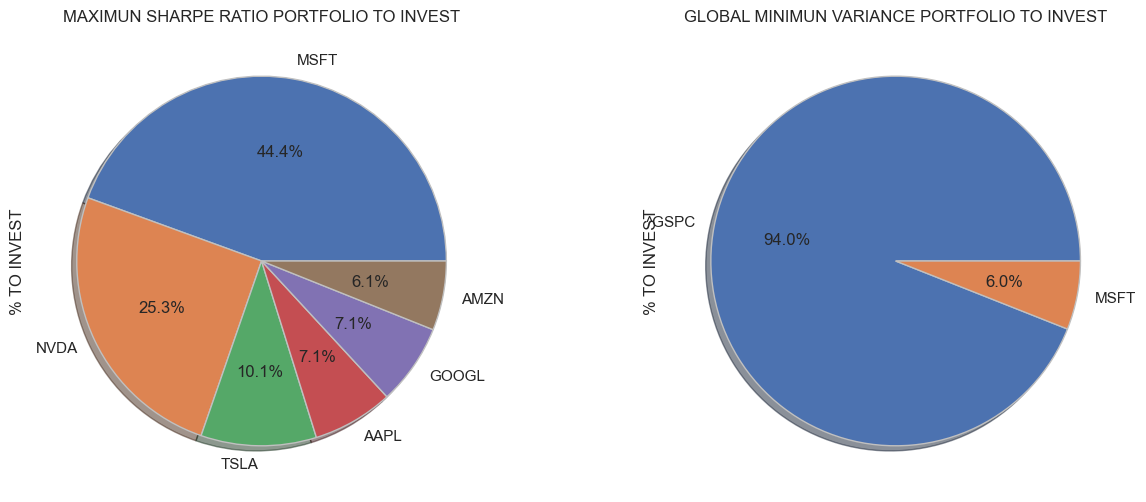

In [ ]:
MG.show_porfolio(FF_EMR, df_mR.cov(), mriskfree)

Annual

In [ ]:
YFFR = MG.convert_to_annual(FF_EMR)
yCov = df_yR.cov()

--------PORTFOLIO SUMMARY--------
-----MAXIMUN SHARPE RATIO------
Exp. Return: 24.58
Exp. Vol: 25.36
Exp. SHARPE: 0.928
----GLOBAL MINIMUN VARIANCE----
Exp. Return: 11.06
Exp. Vol: 14.36
Exp. SHARPE: 0.697


<Axes: title={'center': 'ANNUAL EFFICIENT FRONTIER'}, xlabel='STD Risk', ylabel='Returns'>

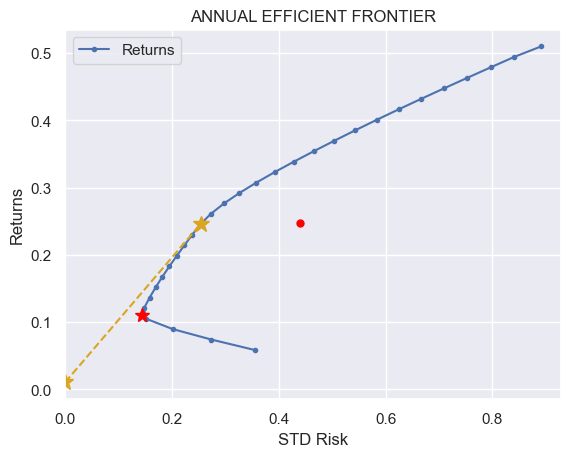

In [ ]:
MG.plot_ef(30, EYR, yCov, yriskfree, "ANNUAL EFFICIENT FRONTIER")

--------PORTFOLIO SUMMARY--------
-----MAXIMUN SHARPE RATIO------
Number of stocks to invest: 4
Ticker
MSFT    58.0
AAPL    25.0
AMZN    10.0
NVDA     7.0
dtype: float64
----GLOBAL MINIMUN VARIANCE----
Number of stocks to invest: 1
Ticker
^GSPC    100.0
dtype: float64


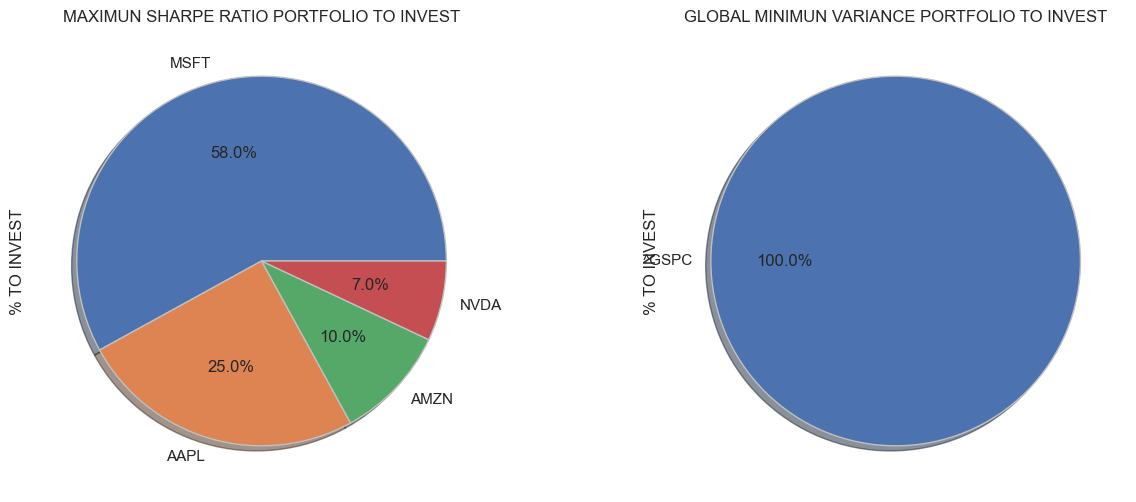

In [ ]:
MG.show_porfolio(YFFR, yCov, yriskfree)